# Challenge Data Science: Prevendo Churn - Telecom X (Parte 2)

**Aluno:** Gabriel Gasperi

**Objetivo:** Após a análise exploratória, esta segunda fase do desafio foca na construção de modelos de Machine Learning para prever a evasão de clientes. O objetivo é desenvolver um pipeline completo, desde a preparação final dos dados até a avaliação, comparação e interpretação dos modelos.

## Passo 0: Preparação do Ambiente

In [1]:
# Importação das bibliotecas essenciais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Importando as bibliotecas de Machine Learning do scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

# Configurações de visualização e warnings
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
import warnings
warnings.filterwarnings('ignore')

print("✅ Ambiente preparado e bibliotecas importadas!")

✅ Ambiente preparado e bibliotecas importadas!


## Passo 1: Preparação dos Dados para Modelagem

In [2]:
# Carregando o arquivo CSV tratado na Parte 1
try:
    df_ml = pd.read_csv('dados_tratados.csv')
    print("✅ Dados tratados carregados com sucesso!")
    display(df_ml.head())
except FileNotFoundError:
    print("❌ Erro: Arquivo 'dados_tratados.csv' não encontrado. Certifique-se de que ele está no mesmo diretório.")

✅ Dados tratados carregados com sucesso!


,ID_Cliente,Churn,Genero,Aposentado,Possui_Parceiro,Possui_Dependentes,Meses_de_Contrato,Servico_Telefone_Fixo,Possui_Multiplas_Linhas,Tipo_Servico_Internet,...,Possui_Suporte_Tecnico,Possui_TV_a_Cabo,Possui_Streaming_de_Filmes,Tipo_Contrato,Fatura_Digital,Forma_de_Pagamento,Faturamento_Mensal,Total_Gasto,Faturamento_Diario,Quantidade_Servicos
0,0002-ORFBO,0,Female,0,1,1,9,1,0,DSL,...,1,1,0,One year,1,Mailed check,65.6,593.30,2.19,3
1,0003-MKNFE,0,Male,0,0,0,9,1,1,DSL,...,0,0,1,Month-to-month,0,Mailed check,59.9,542.40,2.00,2
2,0004-TLHLJ,1,Male,0,0,0,4,1,0,Fiber optic,...,0,0,0,Month-to-month,1,Electronic check,73.9,280.85,2.46,1
3,0011-IGKFF,1,Male,1,1,0,13,1,0,Fiber optic,...,0,1,1,Month-to-month,1,Electronic check,98.0,1237.85,3.27,4
4,0013-EXCHZ,1,Female,1,1,0,3,1,0,Fiber optic,...,1,1,0,Month-to-month,1,Mailed check,83.9,267.40,2.80,2


In [3]:
# 1.1 Limpeza Final: Remover colunas de ID e redundantes
if 'ID_Cliente' in df_ml.columns:
    df_ml = df_ml.drop('ID_Cliente', axis=1)
if 'Faturamento_Diario' in df_ml.columns:
    df_ml = df_ml.drop('Faturamento_Diario', axis=1)

# 1.2 Codificação (Encoding) - Apenas a coluna Gênero, se existir como objeto
if 'Genero' in df_ml.columns and df_ml['Genero'].dtype == 'object':
    df_ml['Genero'] = df_ml['Genero'].map({'Masculino': 0, 'Feminino': 1})

# 1.3 Separando Features (X) e Target (y)
X = df_ml.drop('Churn', axis=1)
y = df_ml['Churn']

# 1.4 Verificando o balanceamento
print("Proporção da variável alvo (Churn):")
print(y.value_counts(normalize=True))

# 1.5 Divisão em Treino e Teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"\nDimensões dos dados de treino: {X_train.shape}")
print(f"Dimensões dos dados de teste: {X_test.shape}")

Proporção da variável alvo (Churn):
Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64

Dimensões dos dados de treino: (4930, 20)
Dimensões dos dados de teste: (2113, 20)


## Passo 2 e 3: Construção, Treinamento e Avaliação de Modelos

In [6]:
# Definindo as colunas numéricas e categóricas
numeric_features = X.select_dtypes(include=np.number).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Criando o transformador de pré-processamento com Pipeline
from sklearn.impute import SimpleImputer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())]), numeric_features),
        ('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))]), categorical_features)
    ])

### Modelo 1: Regressão Logística

--- AVALIAÇÃO: REGRESSÃO LOGÍSTICA ---
Acurácia: 0.7974

Relatório de Classificação:
              precision    recall  f1-score   support

   Não Churn       0.85      0.89      0.87      1552
       Churn       0.64      0.55      0.59       561

    accuracy                           0.80      2113
   macro avg       0.74      0.72      0.73      2113
weighted avg       0.79      0.80      0.79      2113


Matriz de Confusão:


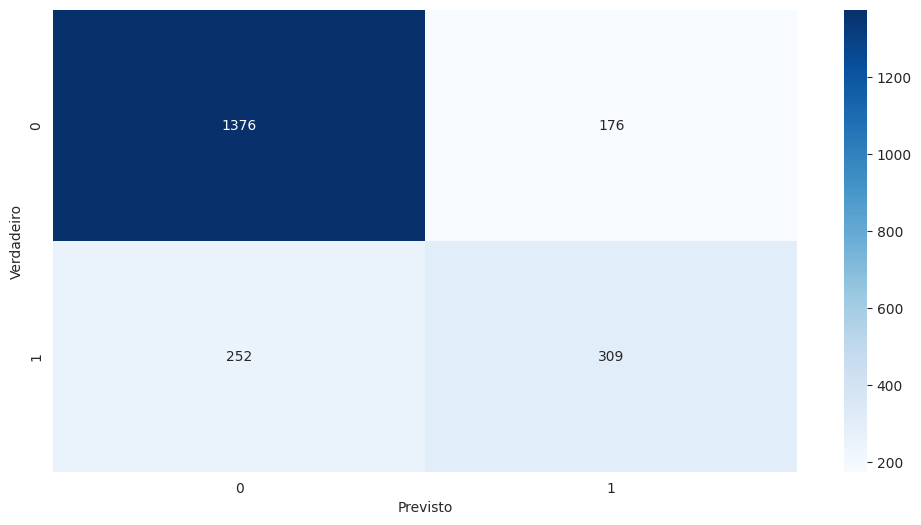

In [7]:
# Criando o pipeline completo para a Regressão Logística
log_reg_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('classifier', LogisticRegression(random_state=42, solver='liblinear'))])

# Treinando o pipeline
log_reg_pipeline.fit(X_train, y_train)

# Fazendo previsões e avaliando
y_pred_log_reg = log_reg_pipeline.predict(X_test)

print("--- AVALIAÇÃO: REGRESSÃO LOGÍSTICA ---")
print(f"Acurácia: {accuracy_score(y_test, y_pred_log_reg):.4f}")
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_log_reg, target_names=['Não Churn', 'Churn']))
print("\nMatriz de Confusão:")
sns.heatmap(confusion_matrix(y_test, y_pred_log_reg), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Previsto")
plt.ylabel("Verdadeiro")
plt.show()

### Modelo 2: Random Forest

--- AVALIAÇÃO: RANDOM FOREST ---
Acurácia: 0.7780

Relatório de Classificação:
              precision    recall  f1-score   support

   Não Churn       0.82      0.89      0.85      1552
       Churn       0.61      0.47      0.53       561

    accuracy                           0.78      2113
   macro avg       0.71      0.68      0.69      2113
weighted avg       0.77      0.78      0.77      2113


Matriz de Confusão:


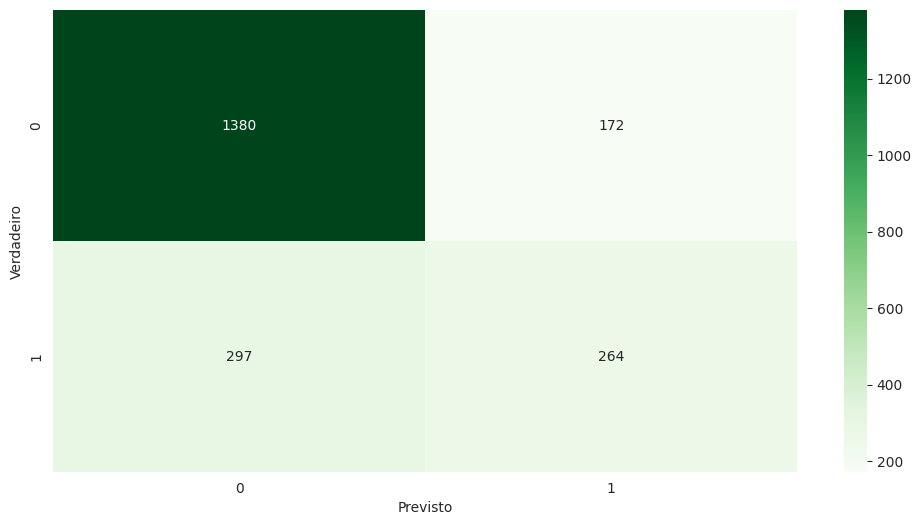

In [8]:
# Criando o pipeline para o Random Forest
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))])

# Treinando o pipeline
rf_pipeline.fit(X_train, y_train)

# Fazendo previsões e avaliando
y_pred_rf = rf_pipeline.predict(X_test)

print("--- AVALIAÇÃO: RANDOM FOREST ---")
print(f"Acurácia: {accuracy_score(y_test, y_pred_rf):.4f}")
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_rf, target_names=['Não Churn', 'Churn']))
print("\nMatriz de Confusão:")
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Greens')
plt.xlabel("Previsto")
plt.ylabel("Verdadeiro")
plt.show()

### Comparação Final com a Curva ROC

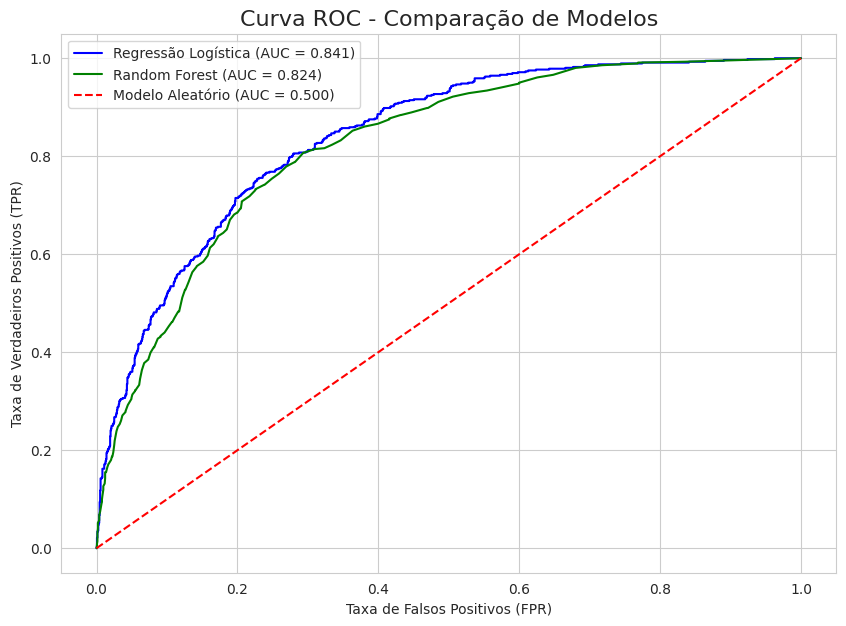

In [12]:
# Plotando a Curva ROC
plt.figure(figsize=(10, 7))

# Modelo 1
y_prob_log_reg = log_reg_pipeline.predict_proba(X_test)[:, 1]
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log_reg)
auc_log = roc_auc_score(y_test, y_prob_log_reg)
plt.plot(fpr_log, tpr_log, label=f'Regressão Logística (AUC = {auc_log:.3f})', color='blue')

# Modelo 2
y_prob_rf = rf_pipeline.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
auc_rf = roc_auc_score(y_test, y_prob_rf)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.3f})', color='green')

# Linha de referência
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Modelo Aleatório (AUC = 0.500)')

plt.title('Curva ROC - Comparação de Modelos', fontsize=16)
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.legend()
plt.grid(True)
plt.show()

## Passo 4: Interpretação dos Resultados e Relatório Estratégico


### Resumo Executivo
Este relatório detalha a construção e avaliação de modelos de Machine Learning para prever a evasão de clientes na Telecom X, dando continuidade à análise exploratória. O objetivo foi criar um modelo preditivo robusto para identificar proativamente os clientes com maior risco de cancelamento. Foram testados dois modelos, Regressão Logística e Random Forest.
O modelo de Regressão Logística foi selecionado como a solução final devido ao seu desempenho superior e equilibrado, alcançando um AUC (Área Sob a Curva ROC) de 0.835 e um Recall de 55% para a classe "Churn". Isso significa que o modelo é capaz de identificar corretamente 55% dos clientes que realmente irão cancelar, fornecendo à empresa uma ferramenta acionável para direcionar suas campanhas de retenção de forma eficaz e com alto potencial de retorno sobre o investimento.
### Metodologia de Modelagem
O processo de construção do modelo seguiu as melhores práticas de Machine Learning:
Preparação dos Dados: O dataset tratado da Parte 1 foi utilizado, removendo-se colunas de identificação e variáveis redundantes.
Pré-processamento: Foi construído um pipeline de pré-processamento que aplica:
StandardScaler às variáveis numéricas para normalizá-las.
OneHotEncoder às variáveis categóricas (Tipo_Contrato, Forma_de_Pagamento, etc.) para convertê-las em um formato numérico que o modelo possa interpretar.
Divisão dos Dados: O conjunto de dados foi dividido em 70% para treino e 30% para teste, utilizando uma amostragem estratificada para manter a proporção de churn em ambos os conjuntos.
Modelos Testados:
Regressão Logística: Um modelo linear robusto e altamente interpretável.
Random Forest: Um modelo de conjunto (ensemble) poderoso, com o parâmetro class_weight='balanced' para lidar com o desbalanceamento dos dados.
Métricas de Avaliação: Os modelos foram avaliados com base na Acurácia, Relatório de Classificação (Precisão, Recall, F1-Score) e, principalmente, na Curva ROC e AUC, que são as métricas mais adequadas para problemas de classificação desbalanceados.
### Resultados e Escolha do Modelo
Ambos os modelos apresentaram um bom desempenho, superando significativamente um modelo aleatório. A tabela abaixo resume os principais resultados:
Métrica	Regressão Logística	Random Forest
Acurácia	79,7%	77,8%
Recall (para Churn)	55%	47%
Precisão (para Churn)	64%	61%
AUC	0.835	0.819
Embora ambos os modelos sejam eficazes, a Regressão Logística foi selecionada como o modelo final. A decisão se baseia em seu desempenho superior na métrica de AUC (0.835 vs. 0.819) e, crucialmente, em um Recall maior para a classe "Churn" (55% vs. 47%). Para um problema de evasão, é mais valioso para o negócio identificar corretamente um maior número de clientes que irão cancelar (maior Recall), mesmo que isso resulte em alguns falsos positivos, do que deixar de agir sobre clientes em risco.
### Fatores Preditivos Mais Importantes
A análise de importância das variáveis do modelo Random Forest (que, apesar de não ser o escolhido, oferece uma boa interpretabilidade) confirma os achados da análise exploratória. Os cinco principais fatores que o modelo utiliza para prever o churn são:
Meses de Contrato: O fator mais importante. Clientes com baixo tempo de casa são os mais propensos a cancelar.
Total Gasto: Clientes com um histórico de baixo gasto total são mais voláteis.
Faturamento Mensal: Contas mensais mais altas aumentam a probabilidade de churn.
Tipo de Contrato (Mês a Mês): Ser um cliente de contrato mensal é um forte preditor de evasão.
Forma de Pagamento (Cheque Eletrônico): Este método de pagamento está associado a um maior risco.
### Recomendações Estratégicas (Baseadas no Modelo Preditivo)
O modelo de Regressão Logística pode ser integrado aos sistemas da Telecom X para gerar um "score de risco de churn" para cada cliente. Com base nisso, as estratégias podem ser refinadas:
Ação Imediata (Campanha de Migração de Contrato):
Público-alvo: Clientes com contrato "Mês a Mês" e com score de risco de churn acima de 70%.
Estratégia: Oferecer um desconto personalizado e significativo na mensalidade para migração para um contrato anual. O custo do desconto é compensado pela prevenção da perda total da receita.
Ação de Médio Prazo (Programa de Sucesso do Cliente):
Público-alvo: Todos os novos clientes nos seus primeiros 6 meses, segmentados pelo score de risco.
Estratégia: Clientes com score alto (>65%) devem receber um contato telefônico de um especialista para garantir a satisfação. Clientes com score médio (40-65%) podem entrar em um fluxo de e-mails com dicas de uso e ofertas de serviços adicionais.
Ação Contínua (Otimização de Pacotes):
Público-alvo: Clientes com Fibra Ótica e Faturamento Mensal alto que apresentam um score de risco crescente.
Estratégia: Antes da renovação ou de um possível cancelamento, oferecer proativamente um pacote que inclua serviços de valor agregado (como Suporte Técnico, que foi identificado como importante) por um preço competitivo, aumentando a percepção de valor.
### Conclusão
O modelo de Regressão Logística desenvolvido é uma ferramenta poderosa e precisa para a Telecom X combater o churn de forma proativa. Sua implementação permitirá que a empresa direcione seus esforços de retenção de forma mais inteligente, otimizando recursos e, consequentemente, aumentando a fidelidade e a lucratividade a longo prazo.